In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
work_pth = '/content/drive/MyDrive/Colab Notebooks/FinalProject'
os.chdir(work_pth)

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizerFast
import torch
from torch.utils.data import DataLoader
from collections import Counter
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn.functional as F

## Data Preprocessing

In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    return text.replace('\n', ' ').replace('\r', ' ').strip()

In [ ]:
# Data Loading
df = pd.read_csv('cv_with_labels_shuffled.csv')
df['CV'] = df['CV'].fillna('').astype(str).apply(clean_text)


In [ ]:
print(len(df))

8068


### DistillBERT Tokenized

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (643 > 512). Running this sequence through the model will result in indexing errors


count    8068.000000
mean      252.665469
std       120.677535
min         2.000000
50%       253.000000
90%       392.000000
95%       454.000000
99%       618.000000
max      1067.000000
dtype: float64


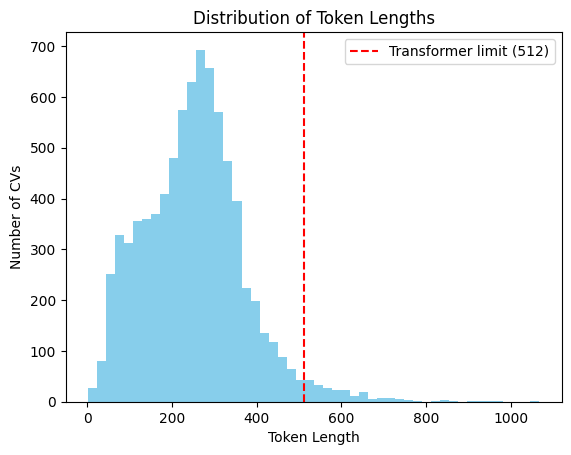

In [ ]:
# Visualization to decide max_length (no need to run again)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

texts = df["CV"].tolist()
encoded = tokenizer(texts, truncation=False, add_special_tokens=True)
token_lengths = [len(x) for x in encoded["input_ids"]]

token_series = pd.Series(token_lengths)
print(token_series.describe(percentiles=[0.5, 0.9, 0.95, 0.99]))

plt.hist(token_lengths, bins=50, color='skyblue')
plt.axvline(512, color='red', linestyle='--', label='Transformer limit (512)')
plt.xlabel("Token Length")
plt.ylabel("Number of CVs")
plt.title("Distribution of Token Lengths")
plt.legend()
plt.show()

In [ ]:
# Data Splitting

texts = df['CV'].tolist()
labels = df['rewritten_y'].tolist()

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.3, stratify=labels, random_state=42
)


val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Create Dataset
import torch

class CV_Dataset(torch.utils.data.Dataset):
    """
    Custom Dataset for BERT tokenized CV texts with binary classification labels.
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Build input dictionary with tokenized input
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add label as tensor (long for classification)
        item['labels'] = torch.tensor(self.labels[idx]).long()
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CV_Dataset(train_encodings, train_labels)
val_dataset = CV_Dataset(val_encodings, val_labels)
test_dataset = CV_Dataset(test_encodings, test_labels)

In [ ]:
# Create DataLoader
from torch.utils.data import DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### prompt2 loader

In [ ]:
# Data processing
df_new = pd.read_csv('cv_with_labels_shuffled_prompt2.csv')
df_new['CV'] = df_new['CV'].fillna('').astype(str).apply(clean_text)
new_test_texts = df_new['CV'].tolist()
new_test_labels = df_new['rewritten_y'].tolist()
# Tokenized
new_test_encodings = tokenizer(new_test_texts, truncation=True, padding=True, max_length=512)
# DataLoader
new_test_dataset = CV_Dataset(new_test_encodings, new_test_labels)
new_test_loader = DataLoader(new_test_dataset, batch_size=batch_size, shuffle=False)


## Modeling - Prompt1 training based

### Baseline Model

In [ ]:
from collections import Counter


counter = Counter(train_labels)
majority_class = counter.most_common(1)[0][0]
print(f"Majority class: {majority_class}")
majority_preds = [majority_class] * len(test_labels)

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

acc = accuracy_score(test_labels, majority_preds)
f1 = f1_score(test_labels, majority_preds)
try:
    auc = roc_auc_score(test_labels, majority_preds)
except:
    auc = float('nan')

print(f"Majority Rule Baseline:\nAccuracy: {acc:.4f}, F1: {f1:.4f}, AUC: {auc}")


Majority class: 1
Majority Rule Baseline:
Accuracy: 0.4996, F1: 0.6663, AUC: 0.5


### HelperFunction

In [ ]:
def set_seed(seed=42):
    """
    Set random seed for reproducibility across different libraries.

    Args:
        seed (int): Random seed value
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

def train_model(model, loss_func, num_epochs, optimizer, train_loader, val_loader):
    train_loss_log = []
    val_loss_log = []
    train_acc_log = []
    val_acc_log = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0
        total_samples = 0
        all_preds = []
        all_labels = []

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_func(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * input_ids.size(0)
            total_samples += input_ids.size(0)

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

        avg_train_loss = total_loss / total_samples
        train_acc = accuracy_score(all_labels, all_preds)

        train_loss_log.append(avg_train_loss)
        train_acc_log.append(train_acc)

        val_loss, val_acc = evaluate_model(model, val_loader, loss_func)
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.4f}, "
              f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

    return train_loss_log, val_loss_log, train_acc_log, val_acc_log


def evaluate_model(model, loader, loss_func):
    model.eval()
    total_loss = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_func(logits, labels)

            total_loss += loss.item() * input_ids.size(0)
            total_samples += input_ids.size(0)

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

    avg_loss = total_loss / total_samples
    acc = accuracy_score(all_labels, all_preds)

    return avg_loss, acc



In [ ]:
def evaluate_on_test(model, test_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_preds = []
    all_probs = []
    all_labels = []
    total_loss = 0
    total_samples = 0
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits, labels)

            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].detach().cpu().numpy())  # 取 positive class 概率
            all_labels.extend(labels.cpu().numpy())

            total_loss += loss.item() * input_ids.size(0)
            total_samples += input_ids.size(0)

    avg_loss = total_loss / total_samples
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"\nTest Loss: {avg_loss:.4f}")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")
    print(f"Label Distribution (0 = Human, 1 = AI): {np.bincount(all_labels)}")

    return {
        'loss': avg_loss,
        'accuracy': acc,
        'f1': f1,
        'auc': auc
    }


In [ ]:
def plot_metrics_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    fig, ax1 = plt.subplots(figsize=(9, 5))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, train_losses, 'r-', label='Train Loss')
    ax1.plot(epochs, val_losses, 'r--', label='Val Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(epochs, train_accs, 'b-', label='Train Acc')
    ax2.plot(epochs, val_accs, 'b--', label='Val Acc')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center')

    plt.title('Loss and Accuracy Curves')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
def print_trainable_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTrainable params: {trainable} / {total} "
          f"({100 * trainable / total:.2f}%)\n")

    print("Layers being tuned:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f" - {name}")

### Model - DistilBERT (last 2 layers trainable) + MLP


In [ ]:
import torch
import torch.nn as nn
from transformers import DistilBertModel

class DistilBERT_MLP(nn.Module):
    def __init__(self, layer_dims=[768, 256, 64, 2], activations=['ReLU', 'Tanh'], freeze_layers=True):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

        if freeze_layers:
            for name, param in self.bert.named_parameters():
                if "transformer.layer.4" not in name and "transformer.layer.5" not in name:
                    param.requires_grad = False

        layers = []
        for i in range(len(layer_dims) - 2):
            layers.append(nn.Linear(layer_dims[i], layer_dims[i+1]))
            act_cls = getattr(nn, activations[i])
            layers.append(act_cls())
            layers.append(nn.Dropout(0.2))
        layers.append(nn.Linear(layer_dims[-2], layer_dims[-1]))
        self.classifier = nn.Sequential(*layers)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]
        logits = self.classifier(cls_output)
        return logits


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1: Train Loss = 0.2001, Train Acc = 0.9366, Val Loss = 0.0366, Val Acc = 0.9876
Epoch 2: Train Loss = 0.0266, Train Acc = 0.9911, Val Loss = 0.0229, Val Acc = 0.9917
Epoch 3: Train Loss = 0.0207, Train Acc = 0.9926, Val Loss = 0.0155, Val Acc = 0.9950


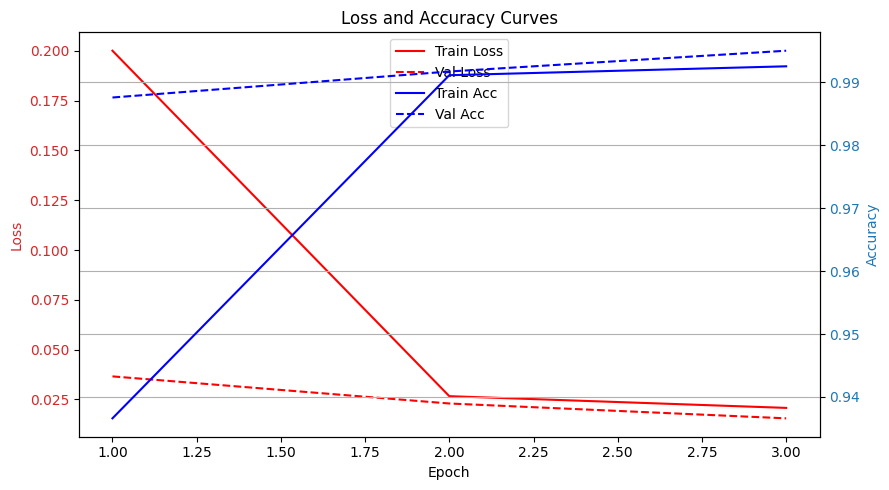


Trainable params: 14701314 / 66888450 (21.98%)

Layers being tuned:
 - bert.transformer.layer.4.attention.q_lin.weight
 - bert.transformer.layer.4.attention.q_lin.bias
 - bert.transformer.layer.4.attention.k_lin.weight
 - bert.transformer.layer.4.attention.k_lin.bias
 - bert.transformer.layer.4.attention.v_lin.weight
 - bert.transformer.layer.4.attention.v_lin.bias
 - bert.transformer.layer.4.attention.out_lin.weight
 - bert.transformer.layer.4.attention.out_lin.bias
 - bert.transformer.layer.4.sa_layer_norm.weight
 - bert.transformer.layer.4.sa_layer_norm.bias
 - bert.transformer.layer.4.ffn.lin1.weight
 - bert.transformer.layer.4.ffn.lin1.bias
 - bert.transformer.layer.4.ffn.lin2.weight
 - bert.transformer.layer.4.ffn.lin2.bias
 - bert.transformer.layer.4.output_layer_norm.weight
 - bert.transformer.layer.4.output_layer_norm.bias
 - bert.transformer.layer.5.attention.q_lin.weight
 - bert.transformer.layer.5.attention.q_lin.bias
 - bert.transformer.layer.5.attention.k_lin.weight
 - b

In [ ]:
model_1 = DistilBERT_MLP(
    layer_dims=[768, 512, 256, 2],
    activations=['GELU', 'ReLU'],
    freeze_layers=True
)

optimizer = torch.optim.AdamW(model_1.parameters(), lr=2e-5)
loss_func = nn.CrossEntropyLoss()

train_loss_log, val_loss_log, train_acc_log, val_acc_log = train_model(
    model_1, loss_func, num_epochs=3, optimizer=optimizer,
    train_loader=train_loader, val_loader=val_loader
)
plot_metrics_curves(train_loss_log, val_loss_log, train_acc_log, val_acc_log)
print_trainable_parameters(model_1)

In [ ]:
evaluate_on_test(model_1, test_loader)


Test Loss: 0.0237
Accuracy : 0.9893
F1 Score : 0.9892
AUC      : 0.9998
Label Distribution (0 = Human, 1 = AI): [606 605]


{'loss': 0.023657915971459532,
 'accuracy': 0.9892650701899257,
 'f1': 0.9891756869275604,
 'auc': np.float64(0.9997899789978999)}

#### Test on prompt2

In [ ]:
evaluate_on_test(model_1, new_test_loader)


Test Loss: 0.9792
Accuracy : 0.7143
F1 Score : 0.8333
AUC      : nan
Label Distribution (0 = Human, 1 = AI): [  0 413]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


{'loss': 0.9791511952444081,
 'accuracy': 0.7142857142857143,
 'f1': 0.8333333333333334,
 'auc': nan}

### (Tune all)  DistillBERT

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1: Train Loss = 0.1494, Train Acc = 0.9602, Val Loss = 0.0235, Val Acc = 0.9942
Epoch 2: Train Loss = 0.0220, Train Acc = 0.9936, Val Loss = 0.0224, Val Acc = 0.9942
Epoch 3: Train Loss = 0.0091, Train Acc = 0.9975, Val Loss = 0.0395, Val Acc = 0.9893


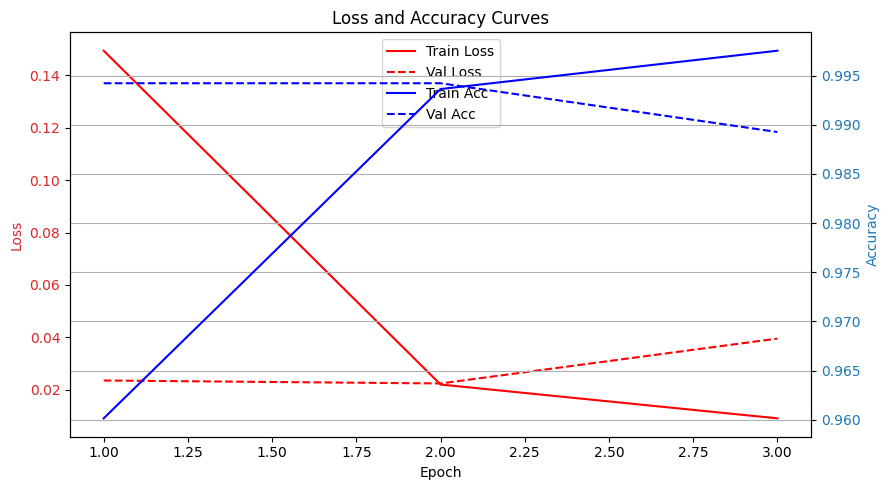


Trainable params: 66888450 / 66888450 (100.00%)

Layers being tuned:
 - bert.embeddings.word_embeddings.weight
 - bert.embeddings.position_embeddings.weight
 - bert.embeddings.LayerNorm.weight
 - bert.embeddings.LayerNorm.bias
 - bert.transformer.layer.0.attention.q_lin.weight
 - bert.transformer.layer.0.attention.q_lin.bias
 - bert.transformer.layer.0.attention.k_lin.weight
 - bert.transformer.layer.0.attention.k_lin.bias
 - bert.transformer.layer.0.attention.v_lin.weight
 - bert.transformer.layer.0.attention.v_lin.bias
 - bert.transformer.layer.0.attention.out_lin.weight
 - bert.transformer.layer.0.attention.out_lin.bias
 - bert.transformer.layer.0.sa_layer_norm.weight
 - bert.transformer.layer.0.sa_layer_norm.bias
 - bert.transformer.layer.0.ffn.lin1.weight
 - bert.transformer.layer.0.ffn.lin1.bias
 - bert.transformer.layer.0.ffn.lin2.weight
 - bert.transformer.layer.0.ffn.lin2.bias
 - bert.transformer.layer.0.output_layer_norm.weight
 - bert.transformer.layer.0.output_layer_norm.b

In [ ]:
model_2 = DistilBERT_MLP(
    layer_dims=[768, 512, 256, 2],
    activations=['GELU', 'ReLU'],
    freeze_layers=False
)

optimizer = torch.optim.AdamW(model_2.parameters(), lr=2e-5)
loss_func = nn.CrossEntropyLoss()

train_loss_log, val_loss_log, train_acc_log, val_acc_log = train_model(
    model_2, loss_func, num_epochs=3, optimizer=optimizer,
    train_loader=train_loader, val_loader=val_loader
)
plot_metrics_curves(train_loss_log, val_loss_log, train_acc_log, val_acc_log)
print_trainable_parameters(model_2)

In [ ]:
evaluate_on_test(model_2, test_loader)


Test Loss: 0.0327
Accuracy : 0.9860
F1 Score : 0.9861
AUC      : 0.9998
Label Distribution (0 = Human, 1 = AI): [606 605]


{'loss': 0.03270332384750733,
 'accuracy': 0.985962014863749,
 'f1': 0.9861450692746536,
 'auc': np.float64(0.9998390748165726)}

#### Test on prompt2

In [ ]:
evaluate_on_test(model_2, new_test_loader)


Test Loss: 0.4932
Accuracy : 0.8329
F1 Score : 0.9089
AUC      : nan
Label Distribution (0 = Human, 1 = AI): [  0 413]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


{'loss': 0.49321203832187605,
 'accuracy': 0.8329297820823245,
 'f1': 0.9088507265521797,
 'auc': nan}

### SHAP Visualization

#### Model1

In [ ]:
!pip install shap

In [ ]:
import shap
import torch
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1.to(device)
def predict_proba(texts):
    model_1.eval()
    outputs = []

    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding='max_length', max_length=512).to(device)

        with torch.no_grad():
            logits = model_1(**inputs)
            probs = torch.softmax(logits, dim=1).cpu().numpy()

        outputs.append(probs[0])

    return np.array(outputs)  # shape: [n_samples, 2]


In [ ]:
explainer = shap.Explainer(predict_proba, tokenizer)

In [ ]:
sample_text = df[df['rewritten_y'] == 1]['CV'].dropna().iloc[0]
shap_values = explainer([sample_text])

shap.plots.text(shap_values[0])

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 2/100 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 4/100 [00:25<06:48,  4.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 5/100 [00:33<09:25,  5.95s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 6/100 [00:42<11:06,  7.09s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 7/100 [00:51<11:50,  7.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 8/100 [01:00<12:16,  8.01s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 9/100 [01:09<12:30,  8.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 10/100 [01:17<12:26,  8.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 11/100 [01:26<12:43,  8.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 12/100 [01:35<12:35,  8.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 13/100 [01:43<12:27,  8.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 14/100 [01:52<12:24,  8.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▌        | 15/100 [02:01<12:11,  8.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 16/100 [02:09<12:04,  8.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 17/100 [02:18<11:59,  8.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 18/100 [02:27<11:54,  8.71s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 19/100 [02:36<11:47,  8.73s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 20/100 [02:44<11:36,  8.71s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 21/100 [02:53<11:27,  8.70s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 22/100 [03:02<11:14,  8.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 23/100 [03:10<11:05,  8.65s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 24/100 [03:19<10:51,  8.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 25/100 [03:27<10:42,  8.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 26/100 [03:36<10:29,  8.51s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 27/100 [03:44<10:23,  8.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 28/100 [03:53<10:21,  8.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 29/100 [04:02<10:12,  8.62s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 30/100 [04:10<10:05,  8.65s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███       | 31/100 [04:19<10:00,  8.70s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 32/100 [04:28<09:48,  8.65s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 33/100 [04:36<09:39,  8.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 34/100 [04:45<09:31,  8.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▌      | 35/100 [04:53<09:17,  8.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 36/100 [05:02<09:12,  8.63s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 37/100 [05:12<09:16,  8.84s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 38/100 [05:20<09:02,  8.75s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 39/100 [05:29<08:47,  8.65s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 40/100 [05:37<08:40,  8.68s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 41/100 [05:46<08:32,  8.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 42/100 [05:55<08:23,  8.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 43/100 [06:03<08:10,  8.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 44/100 [06:12<08:03,  8.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▌     | 45/100 [06:20<07:52,  8.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 46/100 [06:29<07:43,  8.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 47/100 [06:37<07:33,  8.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 48/100 [06:46<07:22,  8.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 49/100 [06:54<07:15,  8.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 50/100 [07:03<07:07,  8.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 51/100 [07:12<07:00,  8.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 52/100 [07:20<06:47,  8.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 53/100 [07:29<06:41,  8.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 54/100 [07:37<06:35,  8.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▌    | 55/100 [07:46<06:30,  8.67s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 56/100 [07:55<06:22,  8.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 57/100 [08:03<06:12,  8.65s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 58/100 [08:12<06:02,  8.62s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 59/100 [08:20<05:49,  8.52s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 60/100 [08:29<05:41,  8.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████    | 61/100 [08:37<05:34,  8.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 62/100 [08:46<05:24,  8.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 63/100 [08:54<05:15,  8.52s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 64/100 [09:03<05:04,  8.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▌   | 65/100 [09:11<04:56,  8.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 66/100 [09:20<04:46,  8.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 67/100 [09:29<04:47,  8.71s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 68/100 [09:37<04:37,  8.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 69/100 [09:46<04:26,  8.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 70/100 [09:55<04:19,  8.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 71/100 [10:04<04:12,  8.70s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 72/100 [10:12<04:05,  8.76s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 73/100 [10:21<03:56,  8.75s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 74/100 [10:30<03:46,  8.71s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 75/100 [10:38<03:36,  8.67s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 76/100 [10:47<03:27,  8.65s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 77/100 [10:55<03:16,  8.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 78/100 [11:04<03:08,  8.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 79/100 [11:13<03:00,  8.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 80/100 [11:21<02:51,  8.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 81/100 [11:30<02:43,  8.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 82/100 [11:38<02:34,  8.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 83/100 [11:47<02:26,  8.62s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 84/100 [11:56<02:18,  8.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▌ | 85/100 [12:04<02:09,  8.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 86/100 [12:13<02:01,  8.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 87/100 [12:22<01:52,  8.62s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 88/100 [12:30<01:42,  8.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 89/100 [12:39<01:34,  8.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 90/100 [12:47<01:26,  8.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 91/100 [12:56<01:17,  8.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 92/100 [13:05<01:08,  8.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 93/100 [13:13<01:00,  8.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 94/100 [13:22<00:52,  8.71s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 95/100 [13:31<00:43,  8.65s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 96/100 [13:39<00:34,  8.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 97/100 [13:48<00:26,  8.67s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 98/100 [13:57<00:17,  8.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 99/100 [14:05<00:08,  8.72s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 100/100 [14:14<00:00,  8.74s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 101it [14:23,  8.72s/it]


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 2/100 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 4/100 [00:25<06:45,  4.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 5/100 [00:34<09:55,  6.26s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 6/100 [00:42<10:55,  6.97s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 7/100 [00:51<11:47,  7.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 8/100 [01:00<12:23,  8.09s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 9/100 [01:08<12:27,  8.21s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 10/100 [01:17<12:19,  8.22s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 11/100 [01:25<12:16,  8.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 12/100 [01:34<12:16,  8.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 13/100 [01:42<12:10,  8.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 14/100 [01:52<12:35,  8.79s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▌        | 15/100 [02:00<12:10,  8.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 16/100 [02:09<12:03,  8.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 17/100 [02:17<11:59,  8.67s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 18/100 [02:26<11:42,  8.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 19/100 [02:34<11:29,  8.51s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 20/100 [02:43<11:24,  8.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 21/100 [02:52<11:27,  8.70s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 22/100 [03:00<11:05,  8.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 23/100 [03:08<10:48,  8.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 24/100 [03:16<10:33,  8.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 25/100 [03:24<10:20,  8.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 26/100 [03:33<10:11,  8.26s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 27/100 [03:41<10:04,  8.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 28/100 [03:50<10:05,  8.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 29/100 [03:58<09:53,  8.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 30/100 [04:07<09:50,  8.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███       | 31/100 [04:15<09:43,  8.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 32/100 [04:23<09:33,  8.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 33/100 [04:32<09:18,  8.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 34/100 [04:40<09:09,  8.33s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▌      | 35/100 [04:48<09:04,  8.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 36/100 [04:56<08:51,  8.31s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 37/100 [05:05<08:47,  8.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 38/100 [05:13<08:35,  8.31s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 39/100 [05:22<08:27,  8.33s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 40/100 [05:30<08:16,  8.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 41/100 [05:38<08:15,  8.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 42/100 [05:47<08:03,  8.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 43/100 [05:56<08:04,  8.51s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 44/100 [06:04<07:48,  8.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▌     | 45/100 [06:12<07:45,  8.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 46/100 [06:20<07:32,  8.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 47/100 [06:29<07:20,  8.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 48/100 [06:37<07:14,  8.35s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 49/100 [06:45<07:03,  8.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 50/100 [06:53<06:53,  8.26s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 51/100 [07:02<06:49,  8.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 52/100 [07:11<06:51,  8.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 53/100 [07:20<06:50,  8.74s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 54/100 [07:29<06:42,  8.76s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▌    | 55/100 [07:37<06:26,  8.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 56/100 [07:45<06:12,  8.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 57/100 [07:54<06:06,  8.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 58/100 [08:02<05:54,  8.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 59/100 [08:11<05:44,  8.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 60/100 [08:19<05:32,  8.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████    | 61/100 [08:27<05:28,  8.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 62/100 [08:36<05:24,  8.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 63/100 [08:44<05:12,  8.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 64/100 [08:53<05:03,  8.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▌   | 65/100 [09:02<05:04,  8.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 66/100 [09:10<04:52,  8.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 67/100 [09:20<04:50,  8.81s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 68/100 [09:28<04:40,  8.76s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 69/100 [09:37<04:27,  8.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 70/100 [09:45<04:17,  8.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 71/100 [09:54<04:09,  8.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 72/100 [10:02<03:58,  8.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 73/100 [10:12<04:00,  8.92s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 74/100 [10:20<03:47,  8.76s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 75/100 [10:29<03:34,  8.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 76/100 [10:37<03:24,  8.52s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 77/100 [10:46<03:17,  8.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 78/100 [10:54<03:06,  8.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 79/100 [11:03<03:01,  8.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 80/100 [11:11<02:50,  8.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 81/100 [11:19<02:39,  8.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 82/100 [11:28<02:33,  8.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 83/100 [11:37<02:24,  8.51s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 84/100 [11:45<02:14,  8.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▌ | 85/100 [11:54<02:07,  8.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 86/100 [12:02<01:57,  8.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 87/100 [12:10<01:50,  8.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 89/100 [12:23<01:17,  7.03s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 90/100 [12:31<01:15,  7.51s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 91/100 [12:40<01:10,  7.84s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 92/100 [12:48<01:03,  7.92s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 93/100 [12:56<00:56,  8.02s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 94/100 [13:05<00:49,  8.29s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 95/100 [13:14<00:42,  8.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 96/100 [13:23<00:34,  8.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 97/100 [13:32<00:25,  8.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 98/100 [13:40<00:17,  8.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 99/100 [13:48<00:08,  8.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 100/100 [13:57<00:00,  8.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 101it [14:06,  8.55s/it]


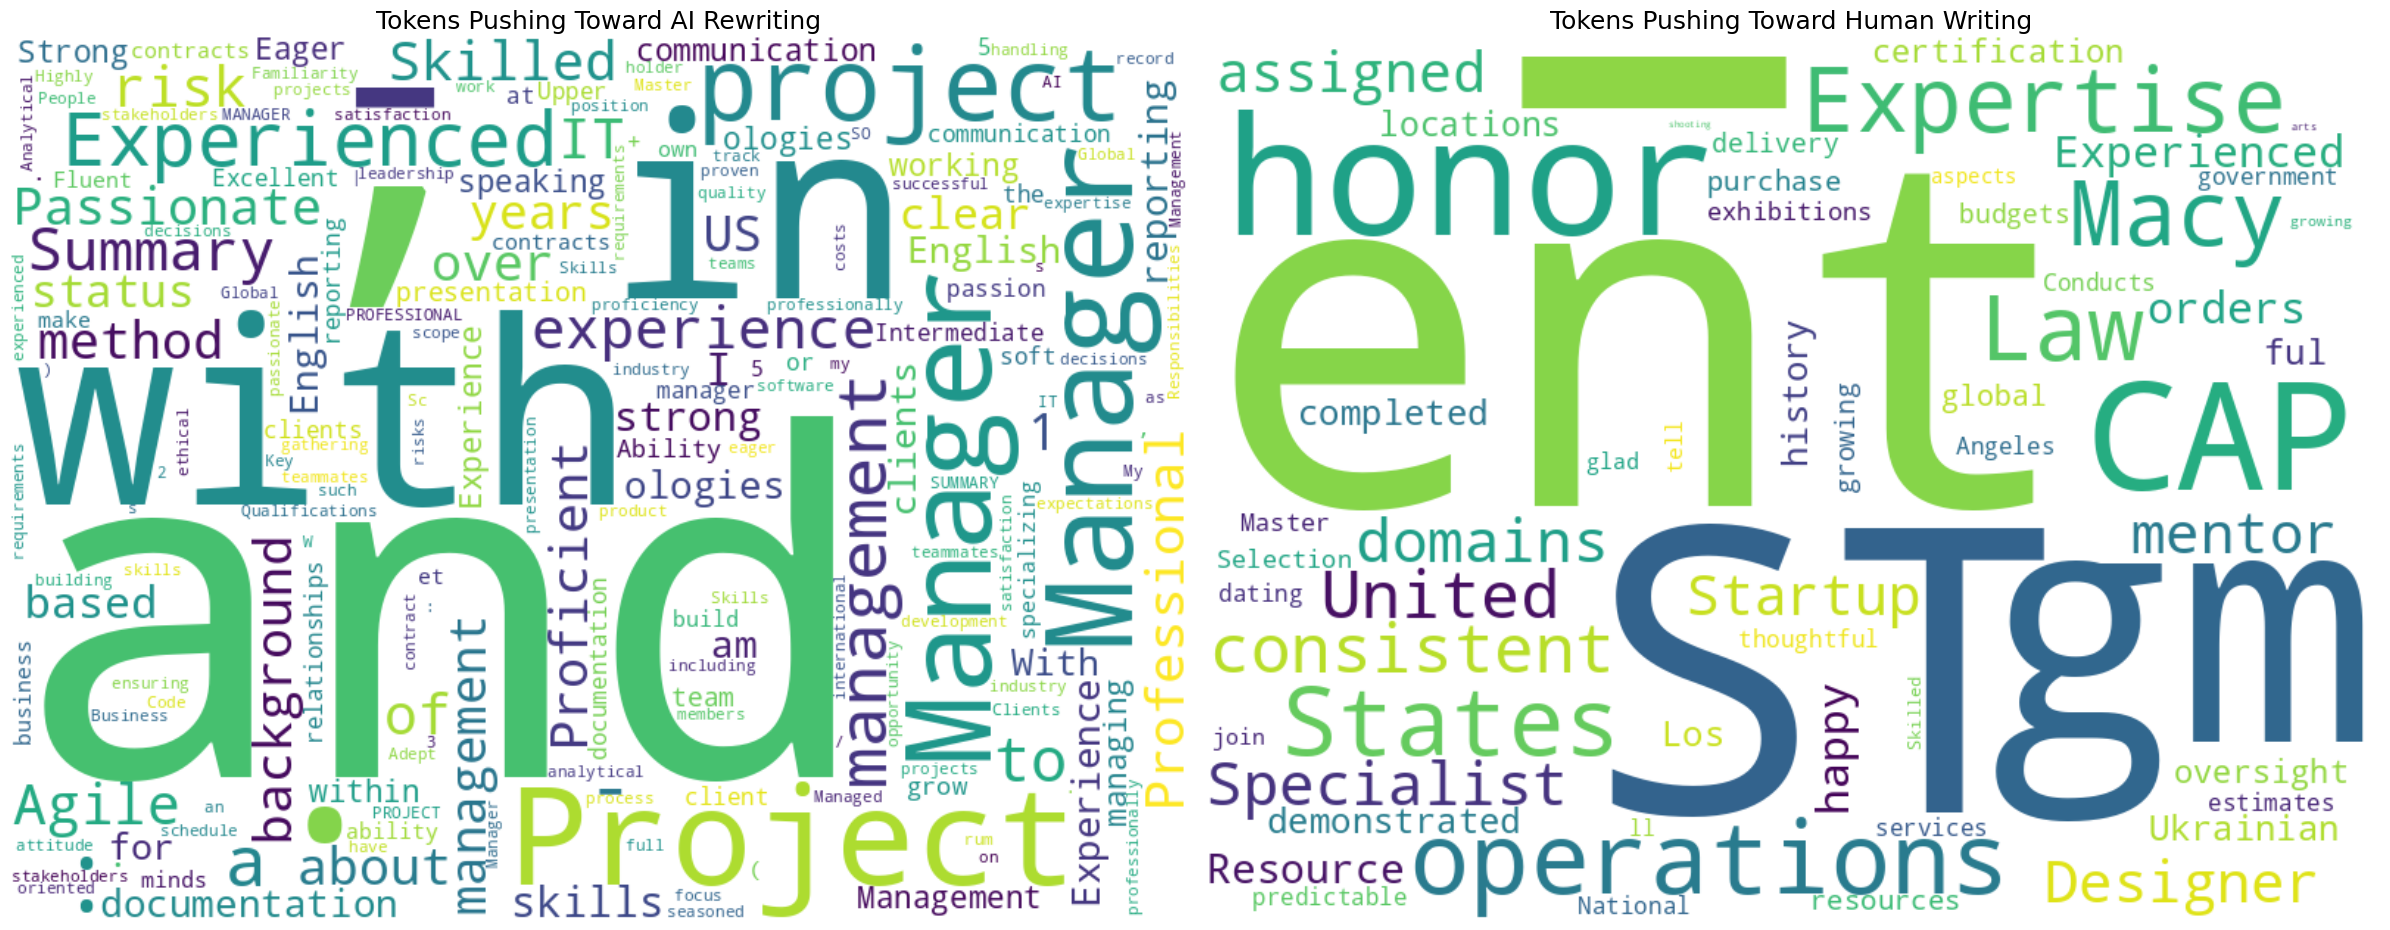

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from wordcloud import WordCloud

texts = df['CV'].dropna().tolist()
probs = predict_proba(texts)  # shape: (n_samples, 2)

df_valid = df[df['CV'].notna()].copy()
df_valid['y_pred'] = (probs[:, 1] > 0.5).astype(int)


ai_texts = df_valid[df_valid['y_pred'] == 1]['CV'].tolist()[:100]
human_texts = df_valid[df_valid['y_pred'] == 0]['CV'].tolist()[:100]

ai_shap = explainer(ai_texts)
human_shap = explainer(human_texts)

def get_token_contributions(shap_values):
    word_scores = defaultdict(float)
    token_strs = shap_values.data
    shap_vals = [v[:, 1] for v in shap_values.values]

    for tokens, vals in zip(token_strs, shap_vals):
        for tok, val in zip(tokens, vals):
            if tok not in ['[CLS]', '[SEP]', '[PAD]', '', '▁']:
                word_scores[tok] += val

    return {k: v for k, v in word_scores.items() if not np.isnan(v)}

ai_scores = get_token_contributions(ai_shap)
human_scores = get_token_contributions(human_shap)

fig, axs = plt.subplots(1, 2, figsize=(24, 10))

wc_ai = WordCloud(width=800, height=600, background_color='white') \
    .generate_from_frequencies(ai_scores)
wc_human = WordCloud(width=800, height=600, background_color='white') \
    .generate_from_frequencies(human_scores)

axs[0].imshow(wc_ai, interpolation='bilinear')
axs[0].set_title("Tokens Pushing Toward AI Rewriting", fontsize=18)
axs[0].axis("off")

axs[1].imshow(wc_human, interpolation='bilinear')
axs[1].set_title("Tokens Pushing Toward Human Writing", fontsize=18)
axs[1].axis("off")

plt.tight_layout()
plt.show()



### TFIDF_LogitModel

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [ ]:
# Data Preprocessing
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_TF = vectorizer.fit_transform(train_texts).toarray()
X_val_TF = vectorizer.transform(val_texts).toarray()
X_test_TF = vectorizer.transform(test_texts).toarray()

In [ ]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_TF, train_labels)

LogisticRegression(max_iter=1000)

In [ ]:
test_preds = clf.predict(X_test_TF)
test_probs = clf.predict_proba(X_test_TF)[:, 1]

test_acc = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds)
test_auc = roc_auc_score(test_labels, test_probs)

print(f"[Test] Accuracy: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")


[Test] Accuracy: 0.9860, F1: 0.9859, AUC: 0.9973


In [ ]:
import numpy as np
import pandas as pd

feature_names = vectorizer.get_feature_names_out()
coefficients = clf.coef_[0]

coef_df = pd.DataFrame({
    'word': feature_names,
    'weight': coefficients
})

top_positive = coef_df.sort_values(by='weight', ascending=False).head(20)
top_negative = coef_df.sort_values(by='weight').head(20)

print("💡 Top tokens pushing prediction toward label 1 (AI Rewritten):")
display(top_positive)

print("💡 Top tokens pushing prediction toward label 0 (Human Original):")
display(top_negative)


💡 Top tokens pushing prediction toward label 1 (AI Rewritten):


word    weight
523                   and  5.147199
7007              project  3.135150
5210           management  2.583990
9707                 with  2.516431
8295               strong  2.462753
2011        communication  2.300117
4245                   in  2.226135
7987               skills  2.194032
3387           experience  2.108581
5177              managed  2.068808
7054   project management  2.006819
1877              clients  1.997768
338   agile methodologies  1.997228
3891               global  1.931557
7641      risk management  1.884758
5580        methodologies  1.802077
7636                 risk  1.781238
3200             ensuring  1.769868
7055      project manager  1.748990
3152              english  1.727056

💡 Top tokens pushing prediction toward label 0 (Human Original):


word    weight
8758         the -3.229454
5966          of -2.004460
9855        work -1.651301
6136      of the -1.406072
2833   different -1.230752
9579         was -1.219758
3284         etc -1.177077
3921        good -1.122427
1245  as project -1.079514
414         also -1.058097
4694          is -1.025595
1221          as -1.017172
4015        have -0.981600
5715        more -0.949774
8919    the team -0.883441
8718        than -0.875568
7921     several -0.850904
5720   more than -0.830227
9672       which -0.829370
378          all -0.822406

#### Test on prompt2

In [ ]:
X_new_test_TF = vectorizer.transform(new_test_texts).toarray()
new_test_preds = clf.predict(X_new_test_TF)
new_test_probs = clf.predict_proba(X_new_test_TF)[:, 1]

new_test_acc = accuracy_score(new_test_labels, new_test_preds)
new_test_f1 = f1_score(new_test_labels, new_test_preds)

print(f"[Test] Accuracy: {new_test_acc:.4f}, F1: {new_test_f1:.4f}")

[Test] Accuracy: 0.8087, F1: 0.8942


## Modeling - Prompt1+Prompt2 training based

In [ ]:
# Mixing dataset
df_orig = pd.read_csv('cv_with_labels_shuffled.csv')
df_prompt2 = pd.read_csv('cv_with_labels_shuffled_prompt2.csv')
df_orig['CV'] = df_orig['CV'].fillna('').astype(str).apply(clean_text)
df_prompt2['CV'] = df_prompt2['CV'].fillna('').astype(str).apply(clean_text)

# Sampling
orig_y0 = df_orig[df_orig['rewritten_y'] == 0].sample(n=1000, random_state=42)
orig_y1_sample = df_orig[df_orig['rewritten_y'] == 1].sample(n=500, random_state=42)


df_mixed = pd.concat([orig_y0, orig_y1_sample, df_prompt2], ignore_index=True)
df_mixed = df_mixed.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Data Preprocessing
texts = df_mixed['CV'].tolist()
labels = df_mixed['rewritten_y'].tolist()

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.3, stratify=labels, random_state=42
)


val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

train_dataset = CV_Dataset(train_encodings, train_labels)
val_dataset = CV_Dataset(val_encodings, val_labels)
test_dataset = CV_Dataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Epoch 1: Train Loss = 0.4363, Train Acc = 0.8715, Val Loss = 0.1588, Val Acc = 0.9408
Epoch 2: Train Loss = 0.1002, Train Acc = 0.9686, Val Loss = 0.1003, Val Acc = 0.9512
Epoch 3: Train Loss = 0.0614, Train Acc = 0.9821, Val Loss = 0.0861, Val Acc = 0.9652


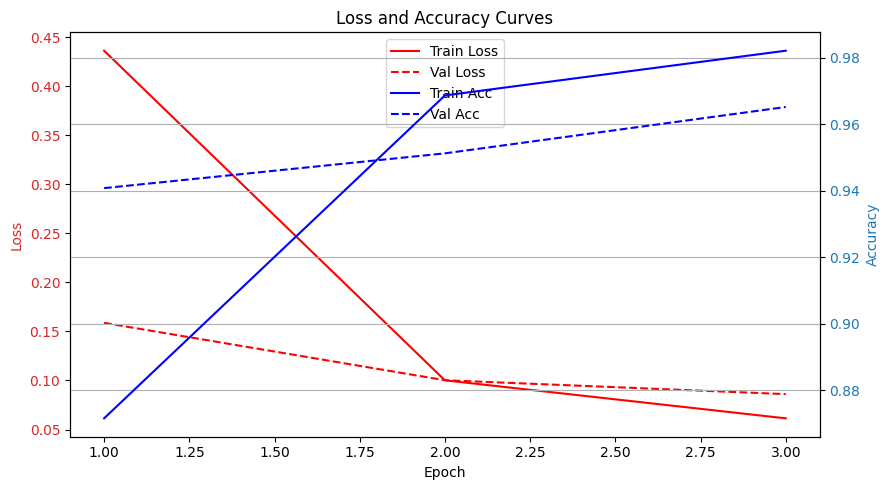


Trainable params: 14701314 / 66888450 (21.98%)

Layers being tuned:
 - bert.transformer.layer.4.attention.q_lin.weight
 - bert.transformer.layer.4.attention.q_lin.bias
 - bert.transformer.layer.4.attention.k_lin.weight
 - bert.transformer.layer.4.attention.k_lin.bias
 - bert.transformer.layer.4.attention.v_lin.weight
 - bert.transformer.layer.4.attention.v_lin.bias
 - bert.transformer.layer.4.attention.out_lin.weight
 - bert.transformer.layer.4.attention.out_lin.bias
 - bert.transformer.layer.4.sa_layer_norm.weight
 - bert.transformer.layer.4.sa_layer_norm.bias
 - bert.transformer.layer.4.ffn.lin1.weight
 - bert.transformer.layer.4.ffn.lin1.bias
 - bert.transformer.layer.4.ffn.lin2.weight
 - bert.transformer.layer.4.ffn.lin2.bias
 - bert.transformer.layer.4.output_layer_norm.weight
 - bert.transformer.layer.4.output_layer_norm.bias
 - bert.transformer.layer.5.attention.q_lin.weight
 - bert.transformer.layer.5.attention.q_lin.bias
 - bert.transformer.layer.5.attention.k_lin.weight
 - b

In [ ]:
model_1_mixed = DistilBERT_MLP(
    layer_dims=[768, 512, 256, 2],
    activations=['GELU', 'ReLU'],
    freeze_layers=True
)

optimizer = torch.optim.AdamW(model_1_mixed.parameters(), lr=2e-5)
loss_func = nn.CrossEntropyLoss()

train_loss_log, val_loss_log, train_acc_log, val_acc_log = train_model(
    model_1_mixed, loss_func, num_epochs=3, optimizer=optimizer,
    train_loader=train_loader, val_loader=val_loader
)
plot_metrics_curves(train_loss_log, val_loss_log, train_acc_log, val_acc_log)
print_trainable_parameters(model_1_mixed)

In [ ]:
evaluate_on_test(model_1_mixed, test_loader)


Test Loss: 0.1159
Accuracy : 0.9617
F1 Score : 0.9603
AUC      : 0.9958
Label Distribution (0 = Human, 1 = AI): [150 137]


{'loss': 0.11591240430075532,
 'accuracy': 0.9616724738675958,
 'f1': 0.9602888086642599,
 'auc': np.float64(0.9957664233576642)}

# Modeling - Prompt1~9 training based

### Data Preprocessing

In [ ]:
# Mixing dataset
df_orig = pd.read_csv('cv_with_labels_shuffled.csv')
df_all = pd.read_csv('cv_with_labels_shuffled_prompt2_9.csv')
df_all.rename(columns={'Rewritten': 'CV'}, inplace=True)
df_orig['CV'] = df_orig['CV'].fillna('').astype(str).apply(clean_text)
df_all['CV'] = df_all['CV'].fillna('').astype(str).apply(clean_text)

# Sampling
df_p1 = df_orig[df_orig['rewritten_y'] == 1].sample(n=658, random_state=42) # prompt1
df_p2 = df_all[df_all['Prompt'] == 2] # Prompt2
df_p3_9 = df_all[df_all['Prompt'].isin([3,4,5,6,7,8,9])] # Prompt3
df_y1 = pd.concat([df_p1, df_p2, df_p3_9], ignore_index=True)
df_y0 = df_orig[df_orig['rewritten_y'] == 0].sample(n=len(df_y1), random_state=42)


df_mixed = pd.concat([df_y1, df_y0], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df_mixed.to_csv('cv_data_full.csv', index=False)

In [ ]:
class CV_Dataset(torch.utils.data.Dataset):
    """
    Custom Dataset for BERT tokenized CV texts with binary classification labels.
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Build input dictionary with tokenized input
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add label as tensor (long for classification)
        item['labels'] = torch.tensor(self.labels[idx]).long()
        return item

    def __len__(self):
        return len(self.labels)

### Model - DistillBERT(last 2 layers trainable) + MLP

In [ ]:
# Data Preprocessing
texts = df_mixed['CV'].tolist()
labels = df_mixed['rewritten_y'].tolist()

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.3, stratify=labels, random_state=42
)


val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

train_dataset = CV_Dataset(train_encodings, train_labels)
val_dataset = CV_Dataset(val_encodings, val_labels)
test_dataset = CV_Dataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Epoch 1: Train Loss = 0.2038, Train Acc = 0.9339, Val Loss = 0.0944, Val Acc = 0.9632
Epoch 2: Train Loss = 0.0675, Train Acc = 0.9761, Val Loss = 0.0911, Val Acc = 0.9678
Epoch 3: Train Loss = 0.0448, Train Acc = 0.9846, Val Loss = 0.0783, Val Acc = 0.9752
Epoch 4: Train Loss = 0.0329, Train Acc = 0.9880, Val Loss = 0.0795, Val Acc = 0.9733
Epoch 5: Train Loss = 0.0241, Train Acc = 0.9925, Val Loss = 0.1714, Val Acc = 0.9531


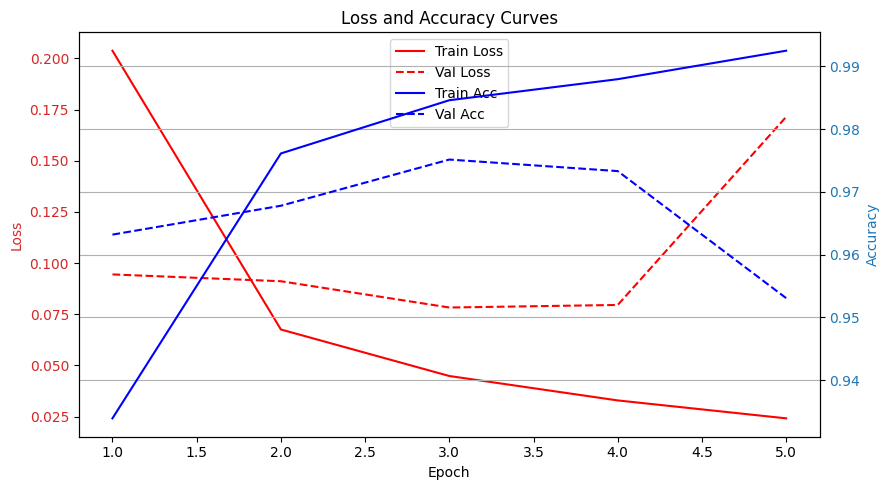


Trainable params: 14701314 / 66888450 (21.98%)

Layers being tuned:
 - bert.transformer.layer.4.attention.q_lin.weight
 - bert.transformer.layer.4.attention.q_lin.bias
 - bert.transformer.layer.4.attention.k_lin.weight
 - bert.transformer.layer.4.attention.k_lin.bias
 - bert.transformer.layer.4.attention.v_lin.weight
 - bert.transformer.layer.4.attention.v_lin.bias
 - bert.transformer.layer.4.attention.out_lin.weight
 - bert.transformer.layer.4.attention.out_lin.bias
 - bert.transformer.layer.4.sa_layer_norm.weight
 - bert.transformer.layer.4.sa_layer_norm.bias
 - bert.transformer.layer.4.ffn.lin1.weight
 - bert.transformer.layer.4.ffn.lin1.bias
 - bert.transformer.layer.4.ffn.lin2.weight
 - bert.transformer.layer.4.ffn.lin2.bias
 - bert.transformer.layer.4.output_layer_norm.weight
 - bert.transformer.layer.4.output_layer_norm.bias
 - bert.transformer.layer.5.attention.q_lin.weight
 - bert.transformer.layer.5.attention.q_lin.bias
 - bert.transformer.layer.5.attention.k_lin.weight
 - b

In [ ]:
model_1_mixed = DistilBERT_MLP(
    layer_dims=[768, 512, 256, 2],
    activations=['GELU', 'ReLU'],
    freeze_layers=True
)

optimizer = torch.optim.AdamW(model_1_mixed.parameters(), lr=2e-5)
loss_func = nn.CrossEntropyLoss()

train_loss_log, val_loss_log, train_acc_log, val_acc_log = train_model(
    model_1_mixed, loss_func, num_epochs=5, optimizer=optimizer,
    train_loader=train_loader, val_loader=val_loader
)
plot_metrics_curves(train_loss_log, val_loss_log, train_acc_log, val_acc_log)
print_trainable_parameters(model_1_mixed)

In [ ]:
evaluate_on_test(model_1_mixed, test_loader)


Test Loss: 0.0994
Accuracy : 0.9733
F1 Score : 0.9739
AUC      : 0.9980
Label Distribution (0 = Human, 1 = AI): [544 543]


{'loss': 0.0993630811614914,
 'accuracy': 0.9733210671573137,
 'f1': 0.9739442946990117,
 'auc': np.float64(0.9979891127721807)}

Epoch 1: Train Loss = 0.2216, Train Acc = 0.9327, Val Loss = 0.1054, Val Acc = 0.9614
Epoch 2: Train Loss = 0.0732, Train Acc = 0.9740, Val Loss = 0.0882, Val Acc = 0.9715
Epoch 3: Train Loss = 0.0474, Train Acc = 0.9848, Val Loss = 0.0979, Val Acc = 0.9650
Epoch 4: Train Loss = 0.0363, Train Acc = 0.9886, Val Loss = 0.1083, Val Acc = 0.9660
Epoch 5: Train Loss = 0.0259, Train Acc = 0.9901, Val Loss = 0.0879, Val Acc = 0.9724


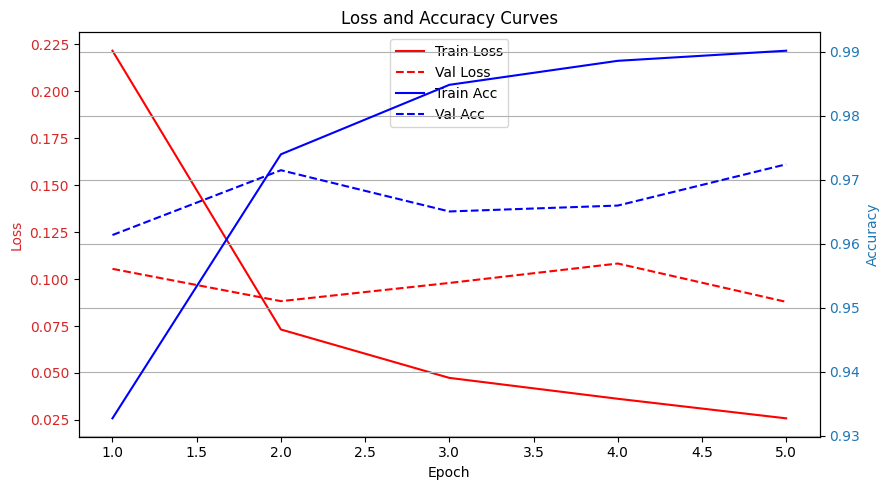


Trainable params: 14438914 / 66626050 (21.67%)

Layers being tuned:
 - bert.transformer.layer.4.attention.q_lin.weight
 - bert.transformer.layer.4.attention.q_lin.bias
 - bert.transformer.layer.4.attention.k_lin.weight
 - bert.transformer.layer.4.attention.k_lin.bias
 - bert.transformer.layer.4.attention.v_lin.weight
 - bert.transformer.layer.4.attention.v_lin.bias
 - bert.transformer.layer.4.attention.out_lin.weight
 - bert.transformer.layer.4.attention.out_lin.bias
 - bert.transformer.layer.4.sa_layer_norm.weight
 - bert.transformer.layer.4.sa_layer_norm.bias
 - bert.transformer.layer.4.ffn.lin1.weight
 - bert.transformer.layer.4.ffn.lin1.bias
 - bert.transformer.layer.4.ffn.lin2.weight
 - bert.transformer.layer.4.ffn.lin2.bias
 - bert.transformer.layer.4.output_layer_norm.weight
 - bert.transformer.layer.4.output_layer_norm.bias
 - bert.transformer.layer.5.attention.q_lin.weight
 - bert.transformer.layer.5.attention.q_lin.bias
 - bert.transformer.layer.5.attention.k_lin.weight
 - b

In [ ]:
model_2_mixed = DistilBERT_MLP(
    layer_dims=[768, 256, 256, 2],
    activations=['ReLU', 'ReLU'],
    freeze_layers=True
)

optimizer = torch.optim.AdamW(model_2_mixed.parameters(), lr=2e-5)
loss_func = nn.CrossEntropyLoss()

train_loss_log, val_loss_log, train_acc_log, val_acc_log = train_model(
    model_2_mixed, loss_func, num_epochs=5, optimizer=optimizer,
    train_loader=train_loader, val_loader=val_loader
)
plot_metrics_curves(train_loss_log, val_loss_log, train_acc_log, val_acc_log)
print_trainable_parameters(model_2_mixed)

In [ ]:
evaluate_on_test(model_2_mixed, test_loader)


Test Loss: 0.0556
Accuracy : 0.9834
F1 Score : 0.9835
AUC      : 0.9985
Label Distribution (0 = Human, 1 = AI): [544 543]


{'loss': 0.055564956671002266,
 'accuracy': 0.983440662373505,
 'f1': 0.9834558823529411,
 'auc': np.float64(0.9984867565810855)}

### Model - DistillBERT(Tune all)  + MLP

Epoch 1: Train Loss = 0.1709, Train Acc = 0.9452, Val Loss = 0.0736, Val Acc = 0.9733
Epoch 2: Train Loss = 0.0490, Train Acc = 0.9838, Val Loss = 0.0725, Val Acc = 0.9770
Epoch 3: Train Loss = 0.0327, Train Acc = 0.9893, Val Loss = 0.0527, Val Acc = 0.9788
Epoch 4: Train Loss = 0.0206, Train Acc = 0.9925, Val Loss = 0.0583, Val Acc = 0.9844
Epoch 5: Train Loss = 0.0103, Train Acc = 0.9968, Val Loss = 0.0904, Val Acc = 0.9798


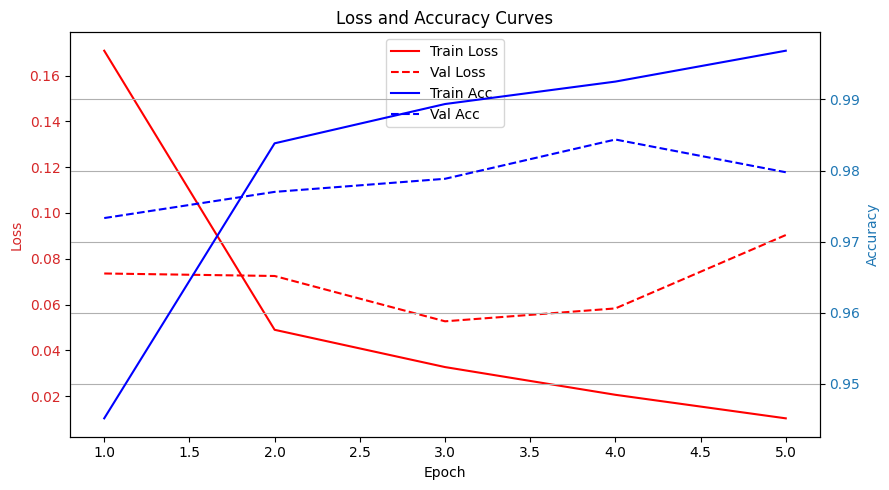


Trainable params: 66888450 / 66888450 (100.00%)

Layers being tuned:
 - bert.embeddings.word_embeddings.weight
 - bert.embeddings.position_embeddings.weight
 - bert.embeddings.LayerNorm.weight
 - bert.embeddings.LayerNorm.bias
 - bert.transformer.layer.0.attention.q_lin.weight
 - bert.transformer.layer.0.attention.q_lin.bias
 - bert.transformer.layer.0.attention.k_lin.weight
 - bert.transformer.layer.0.attention.k_lin.bias
 - bert.transformer.layer.0.attention.v_lin.weight
 - bert.transformer.layer.0.attention.v_lin.bias
 - bert.transformer.layer.0.attention.out_lin.weight
 - bert.transformer.layer.0.attention.out_lin.bias
 - bert.transformer.layer.0.sa_layer_norm.weight
 - bert.transformer.layer.0.sa_layer_norm.bias
 - bert.transformer.layer.0.ffn.lin1.weight
 - bert.transformer.layer.0.ffn.lin1.bias
 - bert.transformer.layer.0.ffn.lin2.weight
 - bert.transformer.layer.0.ffn.lin2.bias
 - bert.transformer.layer.0.output_layer_norm.weight
 - bert.transformer.layer.0.output_layer_norm.b

In [ ]:
model_1_mixed_FROZEN = DistilBERT_MLP(
    layer_dims=[768, 512, 256, 2],
    activations=['GELU', 'ReLU'],
    freeze_layers=False
)

optimizer = torch.optim.AdamW(model_1_mixed_FROZEN.parameters(), lr=2e-5)
loss_func = nn.CrossEntropyLoss()

train_loss_log, val_loss_log, train_acc_log, val_acc_log = train_model(
    model_1_mixed_FROZEN, loss_func, num_epochs=5, optimizer=optimizer,
    train_loader=train_loader, val_loader=val_loader
)
plot_metrics_curves(train_loss_log, val_loss_log, train_acc_log, val_acc_log)
print_trainable_parameters(model_1_mixed_FROZEN)

In [ ]:
evaluate_on_test(model_1_mixed_FROZEN, test_loader)


Test Loss: 0.0532
Accuracy : 0.9899
F1 Score : 0.9899
AUC      : 0.9992
Label Distribution (0 = Human, 1 = AI): [544 543]


{'loss': 0.05319459169564157,
 'accuracy': 0.9898804047838087,
 'f1': 0.989935956084172,
 'auc': np.float64(0.9991942909760589)}

### TFIDF_LogitModel

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [ ]:
# Data Preprocessing
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_TF = vectorizer.fit_transform(train_texts).toarray()
X_val_TF = vectorizer.transform(val_texts).toarray()
X_test_TF = vectorizer.transform(test_texts).toarray()

In [ ]:
clf_mixed = LogisticRegression(max_iter=1000)
clf_mixed.fit(X_train_TF, train_labels)

LogisticRegression(max_iter=1000)

In [ ]:
test_preds = clf_mixed.predict(X_test_TF)
test_probs = clf_mixed.predict_proba(X_test_TF)[:, 1]

test_acc = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds)
test_auc = roc_auc_score(test_labels, test_probs)

print(f"[Test] Accuracy: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

[Test] Accuracy: 0.9724, F1: 0.9719, AUC: 0.9978


In [ ]:
import numpy as np
import pandas as pd

feature_names = vectorizer.get_feature_names_out()
coefficients = clf_mixed.coef_[0]

coef_df = pd.DataFrame({
    'word': feature_names,
    'weight': coefficients
})

top_positive = coef_df.sort_values(by='weight', ascending=False).head(20)
top_negative = coef_df.sort_values(by='weight').head(20)

print("💡 Top tokens pushing prediction toward label 1 (AI Rewritten):")
display(top_positive)

print("💡 Top tokens pushing prediction toward label 0 (Human Original):")
display(top_negative)

💡 Top tokens pushing prediction toward label 1 (AI Rewritten):


word    weight
533                   and  4.561821
5183              managed  3.290429
6975           proficient  3.123504
6976        proficient in  3.086794
4258                   in  2.995121
5017                  led  2.655259
7828              seeking  2.157624
6404              oversaw  2.109559
7984           skilled in  2.085021
8300               strong  2.047117
6408           overseeing  2.044464
353   agile methodologies  2.019072
7983              skilled  1.895347
2150            conducted  1.853519
7009              project  1.843256
5575        methodologies  1.789931
4196          implemented  1.723889
2005        communication  1.716835
2999                eager  1.685431
4475            including  1.672575

💡 Top tokens pushing prediction toward label 0 (Human Original):


word    weight
8757        the -3.723252
5954         of -2.946409
9870       work -2.312320
6127     of the -2.040209
2819  different -1.961157
9590        was -1.795761
9898     worked -1.693141
8734       that -1.605034
9916    working -1.604656
5710       more -1.577530
3282        etc -1.559130
430        also -1.473548
4716         is -1.440157
7916    several -1.395465
3932       good -1.359969
392         all -1.323994
8721       than -1.318488
1230        are -1.306653
5713  more than -1.280724
9682      which -1.280180

## Save Model

In [ ]:
torch.save(model_2_mixed.state_dict(), 'model_2_mixed.pt')
tokenizer.save_pretrained('model_2_tokenizer')
!zip -r model_2_tokenizer.zip model_2_tokenizer

  adding: model_2_tokenizer/ (stored 0%)
  adding: model_2_tokenizer/tokenizer_config.json (deflated 75%)
  adding: model_2_tokenizer/special_tokens_map.json (deflated 42%)
  adding: model_2_tokenizer/vocab.txt (deflated 53%)
  adding: model_2_tokenizer/tokenizer.json (deflated 71%)


In [ ]:
from google.colab import files
files.download('model_2_mixed.pt')
files.download('model_2_tokenizer.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
torch.save(model_1_mixed_FROZEN.state_dict(), 'model_1_mixed_FROZEN.pt')
tokenizer.save_pretrained('model_1_FROZEN_tokenizer')
!zip -r model_1_FROZEN_tokenizer.zip model_1_FROZEN_tokenizer

  adding: model_1_FROZEN_tokenizer/ (stored 0%)
  adding: model_1_FROZEN_tokenizer/tokenizer_config.json (deflated 75%)
  adding: model_1_FROZEN_tokenizer/special_tokens_map.json (deflated 42%)
  adding: model_1_FROZEN_tokenizer/vocab.txt (deflated 53%)
  adding: model_1_FROZEN_tokenizer/tokenizer.json (deflated 71%)


In [ ]:
from google.colab import files
files.download('model_1_mixed_FROZEN.pt')
files.download('model_1_FROZEN_tokenizer.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib
joblib.dump(clf_mixed, 'logit_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [ ]:
files.download('logit_model.pkl')
files.download('tfidf_vectorizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>